# Handling Imports

In [303]:
import torch
import torch.nn as nn                           #imports the neural network module which contains the nn superclass
import torch.optim as optim                     #imports the optimization algorithms such as gradient descent, adam etc
import torch.nn.functional as F                 #has all the parameter-less functions, imports the activation functions(relu etc), but those can also be found in the nn package
from torch.utils.data import DataLoader         #this provides a dataset class for data representation and a dataloader for iterating over the data among other things.
import torchvision.datasets as datasets         #pytorch comes with datasets which can be imported through this
import torchvision.transforms as transforms     #has methods to perform data augmentation operations such as cropping, resizing, normalization etc.
import wandb
from tqdm import tqdm
import pandas as pd

# Creating a CNN

In [304]:
class CNN(nn.Module):
  def __init__(self,in_channels=1,num_classes=10):                                                                       #constructor method which creates the object of the written class
    super(CNN, self).__init__()                                                                                          #super method which inherits the methods from the parent nn.Module class
    self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 8, kernel_size=(3,3), stride=(1,1), padding=(1,1))  #same convolution gives the same dimensions of the image as output
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))                                                           #decreases the image dimensions by 2 times
    self.conv1_bn = nn.BatchNorm2d(8) 
    self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size=(3,3), stride=(1,1), padding=(1,1))           #same convolution 2
    self.conv2_bn = nn.BatchNorm2d(16)
    self.fc1 = nn.Linear(16*7*7, num_classes)                                                                            #fully connectetd layer
    # self.fc1_bn = nn.BatchNorm1d(8*7*7)
    # self.fc2 = nn.Linear(8*7*7, num_classes)
    
  def forward(self, x):              #forward-prop method
    x = self.conv1(x)        #relu activation unit after convolution
    x = self.pool1(x)                #max pool layer
    x = F.relu(self.conv1_bn(x))
    x = self.conv2(x)
    x = self.pool1(x)                #max pool layer
    x = F.relu(self.conv2_bn(x))     #convolutuion + activation unit 2
    x = x.reshape(x.shape[0], -1)    #flatten the output to generate the input for a fully connected layer
    x = self.fc1(x)                  #fully connected layer
    # x = F.relu(self.fc1_bn(x))
    # x = self.fc2(x)
    x = F.softmax(x, dim = 1)
    return x

# computing the mean, std

In [305]:
def mean_std(loader):
  sum, squared_sum, num_batches = 0,0,0
  for data,_ in loader:
    sum += torch.mean(data,dim=[0,2,3])
    squared_sum += torch.mean(data**2,dim=[0,2,3])
    num_batches += 1
  mean = sum/num_batches
  std = (squared_sum/num_batches - mean**2)**0.5
  return mean, std


# Check Accuracy

In [306]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

# Check if the model has any errors in the structure

In [307]:
model = CNN()

#generates a dummy tensor to check the model parameters
x = torch.randn(64, 1, 28, 28)
print(model(x).shape)

torch.Size([64, 10])


# Set Device

In [308]:
 #sets the device to cuda or cpu depending on the avaialability

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Hyperparameters

In [309]:
wandb.login()

True

In [310]:
in_channels = 1
batch_size = 16
learning_rate = 10e-4

#output labels
num_classes = 10

#number of epochs the model is training for
num_epochs = 15

In [311]:
# run = wandb.init(
#     # Set the project where this run will be logged
#     project="mnist",
#     # Track hyperparameters and run metadata
#     config={
#         "learning_rate": learning_rate,
#         "epochs": num_epochs;
#     })


# Transformations

In [312]:
train_transforms = transforms.Compose([ transforms.ToTensor() , transforms.Normalize((0.1307), (0.3081))])

# Load Data

In [313]:
#loading the dataset from pytorch

train_dataset = datasets.MNIST(root='dataset/', train=True, transform=train_transforms, download=True) #downloads the MNIST dataset if it isn't already installed
val_dataset = datasets.MNIST(root='dataset/', train=False, transform=train_transforms, download=True)


# Splitting the dataset into train and val set

In [314]:
#splits the dataset of size 60000 into 50k and 10k respectively for the train and val set

# train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
# print(len(train_set))
# print(len(val_set))
print(len(train_dataset))
print(len(val_dataset))

60000
10000


# Initialzing Data Loaders

In [315]:
#initialzing the data loaders for train,val and test sets respectively

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

# mean,std = mean_std(train_loader)
# print(mean)
# print(std)

# Initialize Network

In [316]:
#initializing the model

model = CNN().to(device)

# Loss and Optimizer

In [317]:
#choosing the loss function and optimizing algorithm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network

In [318]:
train_losses = []
train_accuracies = []

def train(epoch):
    train_loss = 0
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, targets) in loop:
        # get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # so it doesn't store gradients from previous backprops
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        # accumulating loss over an epoch
        train_loss += loss.item()

        train_accuracy = check_accuracy(train_loader, model)

        loop.set_description(f"Epoch [{epoch}/{num_epochs}]")
        loop.set_postfix(f"")

    train_loss = train_loss / len(train_loader)

    # storing the train losses over an epoch in a list
    train_losses.append(train_loss)

    train_accuracies.append(train_accuracy)

    print(f"Epoch [{epoch}/{num_epochs}]")
    print(f"Train_Accuracy={train_accuracy:.2f}, Train_Loss={train_loss:.4f}")


# Validation Loss


In [319]:
# calculating the loss for val_set

val_losses = []
val_accuracies = []

def val(epoch):

   val_loss=0

   with torch.no_grad():
     for batch_idx, (data, targets) in enumerate(val_loader): # dividing into batches is possibly unecessary (will check later)

        #get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        #calling the model with the val data and calculating the loss
        scores = model(data)
        
        val_accuracy = check_accuracy(val_loader, model)
        
        loss = criterion(scores, targets)
        val_loss += loss.item()              #accumulating val loss over an epoch

   val_accuracies.append(val_accuracy)
   
   val_loss = val_loss/len(val_loader)
   val_losses.append(val_loss)  # storing the validation losses over epochs in a list
   
   return val_loss, val_accuracy


# Training the model over epochs


In [320]:
#loops for 20 epochs (will add print statements)

for epoch in range(num_epochs):
    model.train()
    train(epoch)
    model.eval()
    val(epoch)


  0%|          | 0/3750 [00:00<?, ?it/s]

Epoch [0/15]:   1%|          | 33/3750 [07:26<13:57:34, 13.52s/it]


KeyboardInterrupt: 

# Checking the accuracy on training, validation and test sets


In [ ]:
print(f"Accuracy on training set: {check_accuracy(train_loader, model)*100:.2f}") #highest was 99.55
print(f"Accuracy on validation set: {check_accuracy(val_loader, model)*100:.2f}")
# print(f"Accuracy on test set: {check_accuracy(test_loader, model)*100:.2f}") #highest was 98.69

Accuracy on training set: 99.40
Accuracy on validation set: 98.84


# Plotting the Train Loss and Validation loss vs number of epochs

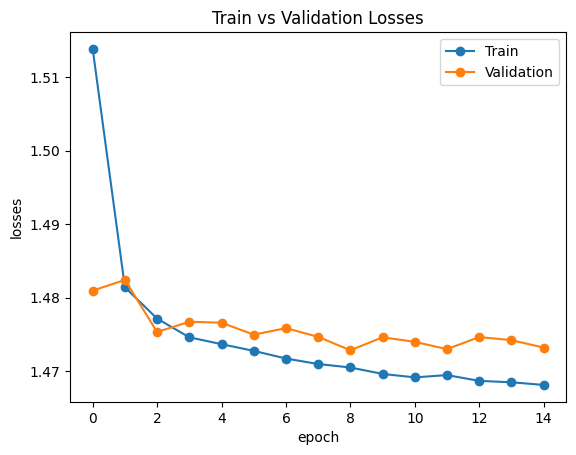

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Validation'])
plt.title('Train vs Validation Losses')

plt.show()

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(count_parameters(model))

9146
